### Import the GitHub Project

In [1]:
!rm -rf project #remove if it already exists 
!git clone https://github.com/B4Farouk/smpl-dr-clip project
!rm -rf sample_data

Cloning into 'project'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 286 (delta 71), reused 53 (delta 21), pack-reused 164
Receiving objects: 100% (286/286), 38.66 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (160/160), done.


### Install Dependencies
---
- pytorch (1.12.1)
- torchvision (0.13.1)
---
- pytorch3d
---
- SMPL
- chumpy

In [2]:
import os
import sys

In [3]:
# install torch
try:
    import torch
    if torch.__version__ != "1.12.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torch==1.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# install torchvision
try:
    import torchvision
    if torchvision.__version__ != "0.13.1":
      raise ModuleNotFoundError()
except ModuleNotFoundError:
    !pip install torchvision==0.13.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# install pytorch3d
import torch, torchvision

try:
    import pytorch3d
except ModuleNotFoundError:
    if torch.__version__.startswith("1.12.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install pytorch3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.3 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221122-py3-none-any.whl size=61484 sha256=40e8e5f3cf41f4d409a5dc690c0a4898af8a09c3ee79514c9ac71d0ee0395c97
  Stored in directory: /root/.cache/pip/wheels/15/6e/e3/602889ca9c5c55020f8d205066445ac5b1b96df59f75170ca0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=18e4f656fe519c83dffd9d3edf526944eb127ae6a8dbef76bf4f9da8016b48b9
  Stored in directory: /root/.cache/pip/wheels/89/3e/24/0f349c0b2eeb6965903035f3b00dbb5c9bea437b4a2f18d82c
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py38_cu113_pyt1121/download.html
     |████████████████████████████████| 47.2 MB 7.7 MB/s 


In [6]:
# install SMPL dependencies
!pip install smplpytorch
!pip install chumpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.0 MB/s 
  Created wheel for chumpy: filename=chumpy-0.70-py3-none-any.whl size=58286 sha256=143f39d1f3690d47d134c5aae8ce9172316cd2569ab7e941b1761017051c0a22
  Stored in directory: /root/.cache/pip/wheels/d9/a2/b8/b8aeeeaeb01b5002085156add1aed832f2fb03e79d0f22dfed
Successfully built chumpy


In [7]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-k_48g6tz
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-k_48g6tz
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=1c3d8939e1a0cacd90f111de7e3abaa91b89b4a2009e3a66a9d25bfcbe7c34bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-htb9qu3s/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


### GPU

In [8]:
torch.cuda.is_available()

True

In [9]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


In [10]:
# GPU or CPU
gpu, cpu = None, None
if torch.cuda.is_available():
    gpu = torch.device("cuda:0")
    torch.cuda.set_device(gpu)
else:
    cpu = torch.device("cpu")
dev = gpu if gpu is not None else cpu
dev

device(type='cuda', index=0)

### Local Imports 

In [11]:
from project.smpl import SMPLwrapper, mesh_from
from project.textures import TexturesFactory
from project.rendering import CamerasFactory, Renderer
from project.clipmodel import CLIPmodel

import clip

import numpy as np

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.8/dist-packages/smplpytorch/pytorch/smpl_layer.py:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


### SMPL

In [12]:
# initalize a textures factory
txfactory = TexturesFactory(device=dev)
# use the texture factory to create a texture generator: a function that takes faces and creates a texture
def texture_generator(faces):
  nfaces = len(faces[0])
  texture = txfactory.from_facecolor(nfaces=nfaces, facecolor=(0.5, 0.5, 0.5))
  return texture
# pose and shape initalization
pose_vect = torch.zeros(1, 72, requires_grad=True, device=dev) # theta
shape_vect = torch.zeros(1, 10, requires_grad=True, device=dev) # beta
# create the smpl model
smpl_model = SMPLwrapper(model=None, txmapping=texture_generator, device=dev) #model=None uses the default model
# create the mesh
mesh = smpl_model.mesh(theta=pose_vect, beta=shape_vect)

### Differentiable Renderer

In [13]:
# create a cameras factory
camsfactory = CamerasFactory(device=dev)
# create a camera using the cameras factory
camera = camsfactory.fov_persp_scs(coords=(2.25, 0, 0), fov=60, frustrum_depth=(1, 100))
# create a renderer
renderer = Renderer(device=dev, cameras=camera)
# render the textured mesh generated by SMPL
image = renderer.render(mesh)

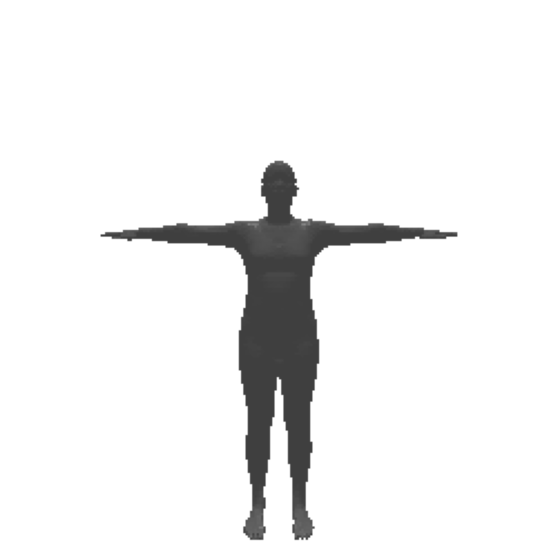

In [14]:
# a quick visualization of the rendered mesh
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(image[0, ..., :3].detach().cpu().numpy())
plt.axis("off");

### CLIP

In [15]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

### CLIP (with PIL Image input)

If this one runs, the other case below will not

In [22]:
clip_model_pil = CLIPmodel(model="RN50")

In [18]:
image = renderer.render(mesh)

image = image.squeeze()
image = torch.permute(image, (2, 0, 1))
image_pil = torchvision.transforms.ToPILImage()(image)

In [20]:
prompt = "apple"
cosine_distance = clip_model_pil.get_cosine_difference(image_pil, prompt)
cosine_distance

0.8341417759656906

In [21]:
prompt = "human"
cosine_distance = clip_model_pil.get_cosine_difference(image_pil, prompt)
cosine_distance

0.8244954198598862

### CLIP (without PIL Image input, handles Image tensors directly)

If this one runs, the other case above will not

In [54]:
clip_model_nopil = CLIPmodel(model="RN50")

In [55]:
image = renderer.render(mesh)

image = image.squeeze()
image = torch.permute(image, (2, 0, 1))
image = image[:3,:,:]

In [56]:
prompt = "apple"
cosine_distance = clip_model_nopil.get_cosine_difference(image, prompt)
cosine_distance

/content/project/clipmodel.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0.8286291360855103

In [57]:
prompt = "human"
cosine_distance = clip_model_nopil.get_cosine_difference(image, prompt)
cosine_distance

0.8218399882316589

### Testing Backpropagation

In [62]:
from project.optimization import OptimEnv
from project.model import build_model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
clip_model = CLIPmodel(model="RN50")
clip_model.eval()
model = build_model(smpl=smpl_model, renderer=renderer, clip_model=clip_model)

In [64]:
optimenv = OptimEnv(model=model, params=[pose_vect])
opti_pose, opti_shape = optimenv.optimize(
    pose=pose_vect, shape=shape_vect, prompt="human standing up", n_passes=1000)
print("optimal pose:\n",opti_pose,"\noptimal shape:\n",opti_shape)

/content/project/clipmodel.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prep_images_tensor = torch.tensor(self.preprocess(image)).cuda().unsqueeze(0)


RuntimeError: ignored